# CNN(Pytorch)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
from keras.datasets import mnist
import matplotlib.pyplot as plt

Using TensorFlow backend.


![](../../picture/pytorch_CONV.png)

这里我们使用Pytorch来实现Minist数据集的CNN网络,该网络模型与Tensorflow中的网络模型极为相似,但是不同点是我们没有在Pool层使用“SAME”,原因稍后解释

## Load Data

这里我们依然使用Keras的数据集,为了电脑(CPU)运行效率,我这里取training set 10K,validation set 0.1K.需要注意的是我们这里的样本shape已经发生变化,即:

$data\;shape:(m,Channels,Height,Width)$

In [2]:
def Load_data(index,limit_train,limit_test):
    """
    Load data set.
    Arguments:
    ---------
        index: show minist digits index.
        limit_train: sample limit of training set,in this case, choose 10K.
        limit_test: sample limit of validation set,in this case,choose 0,1K.
    Returns:
    -------
        x_train: training data set. divide by 255.-->normal
        x_test: testing data set. divide by 255.-->normal
        y_train: training data labels. It's a hot vector, shape is (m,n_classes).
        y_test: testing data labels,a hot vector,shape is (m,n_classes).
    """
    (X_train,Y_train),(X_test,Y_test) = mnist.load_data()
    x_train = X_train[:limit_train,...].reshape(-1,1,28,28)
    x_test = X_test[:limit_test,...].reshape(-1,1,28,28)
    y_train = Y_train[:limit_train]
    y_test = Y_test[:limit_test]
    
    print('x_train reshape:\n',x_train.shape)
    print('x_test reshape:\n',x_test.shape)
    print('y_train shape:\n ',y_train.shape)
    print('y_test shape:\n ',y_test.shape)
    print('The Number is:{}'.format(Y_train[index]))
    plt.imshow(X_train[index],cmap='gray')
    plt.show()
    
    return x_train/255,x_test/255,y_train,y_test

x_train reshape:
 (10000, 1, 28, 28)
x_test reshape:
 (100, 1, 28, 28)
y_train shape:
  (10000,)
y_test shape:
  (100,)
The Number is:5


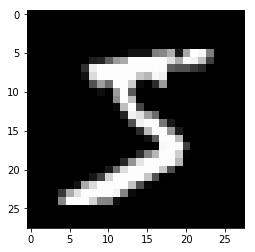

In [3]:
x_train,x_test,y_train,y_test = Load_data(0,10000,100)

可以看到样本可以正常的加载出来,需要再次强调的是此时的$data\;shape(m,Channels,Heights,Width)$,那么接下去我们来看看如何使用Pytorch搭建一个CNN网络.

## Build Pytorch of CNN Model

在使用Pytorch构建CNN之前,我们要先来看看CNN中最重要的两个函数:

1) [torch.nn.Conv2d](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d)

```torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')```

(1.1) in_channels:表示输入数据的通道数

(1.2) out_channels: 表示输出数据的通道数其等于我们的卷积核数量.

(1.3) kernel_size: 卷积核的大小,其可以是一个int类型(int=Heights=Widths),也可以是一个tuple(Heights,Widths)

(1.3) stride: 卷积核的步长,其可以是一个int类型(int=Heights stride=Widths stride),也可以是一个tuple(Heights stride,Widths stride)

(1.4) padding: 数据向外padding的层数,默认为0,其可以是一个int类型(int=Heights pad=Widths pad),也可以是一个tuple(Heights pad,Widths pad)

(1.5) dilation: 卷积的空洞长度,这个参数目前为止我们是不需要理解的,我们在CNN(Theory)最后提到过这个空洞卷积的概念,具体情况查看[link](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)

(1.6) groups: 输入和输入的链接,我们目前也无需理会该参数,在之后我们会在与空洞卷积一起学习.

(1.7) bias: 卷积层的偏置参数,默认为True.

整体Pytorch Conv2d计算的过程为:

对于输入$(N,C_{in},H,W)$经过卷积输出$(N,C_{out},H,W)$计算:

<img src="../../picture/175.png" height=500 width=500>

其中 $\star$表示互相关操作(也就是等价我们的"卷积操作"),两者之间相差一个卷积核的翻转.

正式因为其这样的运算方式,我们需要将**Load Data**的形状更改为$data\;shape(m,Channels,Heights,Width)$.

**PS:**

> 由于dilation的存在,所以我们的CONV输出结果更改为:

> <img src="../../picture/174.png" height=500 width=500>

> 这种方式与我们之前计算CONV输出大小是等价的.

> 观察类Conv2d可以发现,其是没有padding = "SAME"的功能的,也就是说我们需要手动定义padding=“SAME”的方法,依据其计算结果的方式,我们可以反推出如下形式:

> $padding = \frac{(H_{out}-1)*stride + 1 + dilation * (kernel_{size} -1)-H_{in}}{2}$

2) [nn.MaxPool2d](https://pytorch.org/docs/stable/nn.html?highlight=max%20pool#torch.nn.MaxPool2d)

```torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)```

(2.1) kernel_size:卷积核的大小,其可以是一个int类型(int=Heights=Widths),也可以是一个tuple(Heights,Widths)

(2.2) stride:卷积核的步长,其可以是一个int类型(int=Heights stride=Widths stride),也可以是一个tuple(Heights stride,Widths stride)

(2.3) padding: 数据向外padding的层数,默认为0,其可以是一个int类型(int=Heights pad=Widths pad),也可以是一个tuple(Heights pad,Widths pad)

> MaxPool的padding需要注意我们不可以向外pad太多的层数,具体理解为在TF模型中,我们的MaxPool会保证"SAME",那么对于(28,28)的输入,卷积核(2,2),步长(2,2),那么我们需要pad=14才能保证输出的大小为(28,28).不过可惜的是,在Pytorch中,该pad数量过大,导致无法padding.

> 详情请看[github-pytorch](https://github.com/pytorch/pytorch/issues/3298),其中解释为:

> <img src="../../picture/176.png" height=500 width=500>

> 大概意思是MaxPool的初始值为```-inf```,如果padding值太大,可能会在边界中有值.

> Pytorch官方人员apaszke建议可以使用```torch.nn.functional.pad```进行手动填充.

> 以上就是我们对于该模型为什么不在MaxPool层padding的原因,实际上我们也很少会在Pool上使用padding.

(2.4) dilation:同Conv2d中的解释

(2.5) return_indices:是否返回感受野的最大索引.

(2.6) ceil_mode:当感受野不能完整滑过输入,那么将取floor(向下取整)的模式.

### Pytorch of CNN

懂得了CNN中最重要的两个函数,那么我们下面就可以开始构建CNN模型.

整体的模型架构为:

[1] 卷积层:

```python
self.CONV = nn.ModuleDict({
            'conv1':self.CONV2D((5,5,1,32),(1,1)),
            'relu1':nn.ReLU(),
            'pool1':self.POOL2D((2,2),(2,2),method_="VALID"),
            'conv2':self.CONV2D((5,5,32,64),(1,1)),
            'relu2':nn.ReLU(),
            'pool2':self.POOL2D((2,2),(2,2),method_="VALID")
        })```
        
对于```CONV2D(self,kernels,strides,dilation=(1,1),method_="SAME"):```

(1.1) 我们先获取```kernels```,```strides```,```method_```的参数值,如果```method_```是"SAME",那么我们就需要根据上述公式计算padding值.让后按照参数形式依次放入即可.需要注意的是,其参数只能接受为int类型.

```python
p_h = int(((self.n_h-1)*s_h+1+d_w*(f_h-1)-self.n_h) /2)
p_w = int(((self.n_w-1)*s_w+1+d_h*(f_w-1)-self.n_w) /2)```

(1.2) 接下去,我们需要更改```slef.n_h,self.n_w,self.n_c```,因为我们使用的类变量,经过conv后三者都会改变.我们需要重新赋值才能使得下面的Pool或者CONV成功运行,否则```slef.n_h,self.n_w,self.n_c```还是原来第一次CONV的参数,并不适合后面的CONV或POOl.也就是说,如果我们输入的是$(10000,1,28,28)$,经过$F=(5,5,1,32),S=1,padd=SAME$,那么输出的即为$(10000,32,28,28)$,那么我们就需要重新更新```slef.n_h=28,self.n_w=28,self.n_c=32```.

```python
# change n_h,n_w,n_c
self.n_h = self.n_h
self.n_w = self.n_w
self.n_c = f_m```

(1.2.1) 如果我们选择的模式是"VALID",那么我们需要重新计算输出大小并重新赋值

```python
# change n_h,n_w,n_c
self.n_h = int((self.n_h + 2*p_h-d_h*(f_h-1)-1) / s_h + 1)
self.n_w = int((self.n_w + 2*p_w-d_w*(f_w-1)-1) / s_w + 1)
self.n_c = f_m```


[1.1] Pool层:

```POOL2D(self,kernel_size,strides,dilation=(1,1),method_="SAME")```:

该函数整体思想是和CONV2D层是一样的,不同的是由于POOL并不会改变数据的$Channels$,所以我们并不需要重新赋值```self.n_c```.

[2] 全连接层:

```python
self.fully_connected = nn.ModuleDict({
            'FC3':self.FC(3136,1024),
            'relu3':nn.ReLU(),
            'dropout3':self.DROPOUT(0.3),
            'FC4':self.FC(1024,10)
        })```
        
应为我们最后POOL2输出的大小为$(64,7,7)$,将其展平即为:3136作为输入,我们输出为1024.则该层就是FC3.

接下去我们使用```Dropout rate=0.3```来确保大约30%的神经节点停止工作以防止模型过拟合.

最后一层输入为$(1024)$,输出为$(10)$即可,但是需要注意的是,由于我们选择的损失函数为```nn.CrossEntropyLoss```,所以我们不能使用```torch.softmax()```激活函数.



In [4]:
class Forward(nn.Module):
    """
    Build Pytorch class.
    """
    def __init__(self,data_shape):
        """
        Initialization class.
        
        Arguments:
        ---------
            data_shape: shape of data, the shape (n_c,n_h,n_w). to using CONV and Pool.
                        In each layer, n_c,n_h,n_w maby changed.
        """
        nn.Module.__init__(self)
        
        self.n_c,self.n_h,self.n_w = data_shape
        # CONV layers. 
        # CONV1-->RELU1-->POOL1-->CONV2-->RELU2-->POOL2.
        self.CONV = nn.ModuleDict({
            'conv1':self.CONV2D((5,5,1,32),(1,1)),
            'relu1':nn.ReLU(),
            'pool1':self.POOL2D((2,2),(2,2),method_="VALID"),
            'conv2':self.CONV2D((5,5,32,64),(1,1)),
            'relu2':nn.ReLU(),
            'pool2':self.POOL2D((2,2),(2,2),method_="VALID")
        })
        # Fully Connected
        # (3136,1024) -->dropout(0.3) --> (1024,10),notic,do not use activated function.
        self.fully_connected = nn.ModuleDict({
            'FC3':self.FC(3136,1024),
            'relu3':nn.ReLU(),
            'dropout3':self.DROPOUT(0.3),
            'FC4':self.FC(1024,10)
        })
        
        
    
    def forward(self,X):
        """
        Build Model Forward Propagation
        
        Arguments:
        ---------
            X: training data set,the shape is (m,n_c,n_h,n_w).
        
        Returns:
        -------
            X: FC4 layer out, the shape is (m,n_classes). No activate function.
        """
        X = self.CONV['conv1'](X)
        X = self.CONV['relu1'](X)
        X = self.CONV['pool1'](X)
        
        X = self.CONV['conv2'](X)
        X = self.CONV['relu2'](X)
        X = self.CONV['pool2'](X)
        m,_,_,_,= X.size()
        X = torch.reshape(X,(m,-1)) # flatten data ,the shape is (m,-1).-1 = n_c*n_w,n_h

        X = self.fully_connected['FC3'](X)
        X = self.fully_connected['relu3'](X)
        X = self.fully_connected['dropout3'](X)
        X = self.fully_connected['FC4'](X)
            
        return X
    
    def CONV2D(self,kernels,strides,dilation=(1,1),method_="SAME"):
        """
        CONV layers
        
        Arguments:
        ---------
            kernels: convolution kernel,the shape is (f_h,f_w,f_c,f_m).
            strides: convolution stride,the shape is (s_h,s_w).
            dilation: dilation size
            method_: shoose convolution method, default "SAME",can choose "VALID".
        
        Returns:
        -------
            conv2d_: convolution layer output value,the shape is (m,f_m,n_h,n_w).m: number of batch size.
        """
        f_h,f_w,f_c,f_m = kernels
        
        s_h,s_w = strides
        d_h,d_w = dilation
        
        if method_ == "SAME":
            p_h = int(((self.n_h-1)*s_h+1+d_w*(f_h-1)-self.n_h) /2)
            p_w = int(((self.n_w-1)*s_w+1+d_h*(f_w-1)-self.n_w) /2)
            conv2d_ = nn.Conv2d(self.n_c,f_m,
                                kernel_size=(f_h,f_w),
                                stride=(s_h,s_w),
                                padding=(p_h,p_w),
                                dilation=(d_h,d_w))
            
            # change n_h,n_w,n_c
            self.n_h = self.n_h
            self.n_w = self.n_w
            self.n_c = f_m
            
        elif method_ == "VALID":
            p_h = 0
            p_w = 0
            conv2d_ = nn.Conv2d(self.n_c,
                                f_m,
                                kernel_size=(f_h,f_w),
                                stride=(s_h,s_w),
                                dilation=(d_h,d_w))
            
            # change n_h,n_w,n_c
            self.n_h = int((self.n_h + 2*p_h-d_h*(f_h-1)-1) / s_h + 1)
            self.n_w = int((self.n_w + 2*p_w-d_w*(f_w-1)-1) / s_w + 1)
            self.n_c = f_m
            
        else:
            raise ValueError('valid method %s'%method)
        
        return conv2d_
    
    
    def POOL2D(self,kernel_size,strides,dilation=(1,1),method_="SAME"):
        """
        MAX POOL layers.
        
        Arguments:
        ---------
            kernel_size: Pooling layer kernel size,the shape is (f_h,f_w).
            strides: Pooling layer stride,the shape is (s_h,s_w).
            dilation: dilation shape.
            method_: Pooling method, can choose "SAME","VALID",default "SAME".
        
        Returns:
        -------
            max_pool2d: maxed pool value,the shape is (m,f_m,n_h,n_w)
        """
        f_h,f_w = kernel_size
        s_h,s_w = strides
        d_h,d_w = dilation
        if method_ == "SAME":
            p_h = int(((self.n_h-1)*s_h+1+d_h*(f_h-1)-self.n_h) /2)
            p_w = int(((self.n_w-1)*s_w+1+d_w*(f_w-1)-self.n_w) /2)
            max_pool2d = nn.MaxPool2d(kernel_size=(f_h,f_w),stride=strides,padding=(p_h,p_w),dilation=(d_h,d_w))
            # change n_h,n_w,n_c
            self.n_h = self.n_h
            self.n_w = self.n_w
            
        elif method_ == "VALID":
            p_h = 0
            p_w = 0
            max_pool2d = nn.MaxPool2d(kernel_size=(f_h,f_w),stride=strides,dilation=(d_h,d_w))
            # change n_h,n_w,n_c
            self.n_h = int((self.n_h + 2*p_h-d_h*(f_h-1)-1) / s_h + 1)
            self.n_w = int((self.n_w + 2*p_w-d_w*(f_w-1)-1) / s_w + 1)
        else: 
            raise ValueError('valid method %s'%method)
            
        return max_pool2d
    
    def FC(self,Input_shape,Output_shape):
        """
        FULLY-CONNECT layer.caculate linear value.
        
        Arguments:
        ---------
            Input_shape: Input data shape,the shape is (m,n_c*n_w,n_h)
            Output_shape: Output data shape,the shape is (m,n_C*n_w,n_h)
        Returns:
        -------
            linear_: linear layer output value.
        """
        linear_ = nn.Linear(Input_shape,Output_shape)
        nn.init.xavier_normal_(linear_.weight)
        return linear_
    
    
    def DROPOUT(self,rate):
        """
        Dropout layers.
        
        Arguments:
        ---------
            rate: dropout rate,the rate =1-keep_probb
        Return:
        ------
            dropout_: dropout layer output value.
        """
        dropout_ = nn.Dropout(p=rate)
        return dropout_
        

现在我们可以来尝试一下输入数据$(100,1,28,28)$经过Forward.

In [5]:
with torch.no_grad():
    test_data = x_train[:100]
    test_data_tensor = Variable(torch.FloatTensor(test_data)) # you need set type is float tensor.
    data_shape = test_data.shape
    model_test = Forward(data_shape[1:])
    out = model_test.forward(test_data_tensor)
    print(out.shape)

torch.Size([100, 10])


可以看到输出的结果是正确的形状,接下去我们开始构建整个CNN模型架构.

### Score Function

现在我们开始搭建Score函数.

In [6]:
def Score(model,cost,data,labels,is_loss=False):
    """
    Socre function.
    
    Arguments:
    ---------
       cost: cost function to caculate loss value.
       data: score data, the shape is (m,n_c,n_h,n_w).
       labels: score data labes. The shape is (m,)
       is_loss: caculate loss value,if is equal True.
    Returns:
    -------
        accuracy: correct rate in current epoch.
        loss: loss value in currcet epoch,if is euqal True.
    """
    model.eval() # set pytorch model is testing model.
    out = model.forward(data)
    predict = torch.argmax(torch.softmax(out,dim=1),dim=1)
    correct = torch.eq(predict,labels).type(torch.FloatTensor)
    accuracy = torch.mean(correct)
    if is_loss:
        loss = cost(out,labels)
        return accuracy,loss
    else:
        return accuracy

## CNN Model

现在我们可以开始搭建完整版本的CNN Model.与之前的Pytorch一样.

首先我们创建用于Score函数的```data```以及```val_data```,由于其不需要计算反向渐变,所以我们使用```with torch.no_grad():```.

第二,我们使用pytorch自带的batch划分方式:

```python
data_set = Data.TensorDataset(X,y)
loder = Data.DataLoader(dataset=data_set,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)```

需要注意的是需要将```shuffle=True```以防止过拟合.

In [7]:
def CNN_Model(data,labels,val_data,val_labels,epochs,lr,BATCH_SIZE):
    """
    Build CNN Model.
    
    Arguments:
    ---------
        data: training data set. the shape is (m,n_c,n_h,n_w)
        labels: training labels,the shape is (m,)
        val_data: validation data set, the shape equal data shape.
        val_labels: validation labels, the shape equal labels shape.
        epochs: Number of iterate.
        lr: learning rate.
        BATCH_SIZE: batch size for each epoc training.
    """
    m,n_c,n_h,n_w = data.shape
    
    with torch.no_grad():
        data_tensor = Variable(torch.FloatTensor(data))
        labels_tensor = Variable(torch.LongTensor(labels))
        val_data_tensor = Variable(torch.FloatTensor(val_data))
        val_labels_tensor = Variable(torch.LongTensor(val_labels))
        
    # build model.
    model = Forward((n_c,n_h,n_w))
    # set loss function, notic, the labels shape must be (m,),it unacceptable shape like (m,n_classes)!!.
    cost = nn.CrossEntropyLoss()
    # choose adam optimizer.
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    # create Variable.
    X = Variable(torch.FloatTensor(data))
    y = Variable(torch.LongTensor(labels))
    # Spliting data set.It's return tuple(mini_x,mini_y)
    data_set = Data.TensorDataset(X,y)
    loder = Data.DataLoader(dataset=data_set,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)
    

    # Start training 
    for epoch in range(epochs):
        # set pytorch training model.
        model.train()
        for mini_x,mini_y in loder:
            
            out = model.forward(mini_x)
            loss = cost(out,mini_y)
            optimizer.zero_grad() # clear grad.
            loss.backward() # start backward.
            optimizer.step() # updating parameters.
        
        if epoch % 1 == 0:
            
            acc_train,loss_train = Score(model,cost,data_tensor,labels_tensor,is_loss=True)
            acc_val,loss_val = Score(model,cost,val_data_tensor,val_labels_tensor,is_loss=True)
            
            print('[{}/{}] train acc:{:.4f},train loss:{:.4f},val acc:{:.4f},val loss:{:.4f}'.format(epoch+1,
                                                                                                    epochs,
                                                                                                    acc_train,
                                                                                                    loss_train,
                                                                                                    acc_val,
                                                                                                    loss_val))
            

In [8]:
CNN_Model(x_train,y_train,x_test,y_test,10,lr=1e-4,BATCH_SIZE=100)

[1/10] train acc:0.8873,train loss:0.3945,val acc:0.9100,val loss:0.3459
[2/10] train acc:0.9239,train loss:0.2610,val acc:0.9400,val loss:0.2245
[3/10] train acc:0.9433,train loss:0.1977,val acc:0.9700,val loss:0.1539
[4/10] train acc:0.9522,train loss:0.1662,val acc:0.9600,val loss:0.1314
[5/10] train acc:0.9589,train loss:0.1422,val acc:0.9700,val loss:0.1102
[6/10] train acc:0.9688,train loss:0.1110,val acc:0.9900,val loss:0.0655
[7/10] train acc:0.9745,train loss:0.0926,val acc:0.9900,val loss:0.0569
[8/10] train acc:0.9784,train loss:0.0805,val acc:0.9900,val loss:0.0718
[9/10] train acc:0.9798,train loss:0.0709,val acc:0.9900,val loss:0.0465
[10/10] train acc:0.9829,train loss:0.0638,val acc:0.9900,val loss:0.0441


可以看到经过10个epochs,得到的结果training accuracy为0.9879,testing accuracy 为 1.0.

Congratulations,你已经学会如何使用Pytorch搭建一个简单的CNN模型.